In [16]:
import os
import sys


current_dir = os.getcwd()
if os.path.exists(os.path.join(current_dir, 'src')):
    project_root = current_dir
else:
    project_root = os.path.dirname(current_dir)

if project_root not in sys.path:
    sys.path.append(project_root)

print(f"📂 Project Root: {project_root}")

try:
    from src.models.models import get_model
    print("✅ Module 'src' loaded successfully!")
except ImportError as e:
    print(f"❌ Still cannot import src: {e}")
    print(f"Current sys.path: {sys.path}")

import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
from src.preprocessing.dataset import create_dataloaders

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = 'efficientnet_b3'
BATCH_SIZE = 32
IMG_SIZE = 384 
NUM_CLASSES = 27

# Paths
BASELINE_HIST = os.path.join(project_root, 'results', 'history_resnet50.json')
FINAL_HIST = os.path.join(project_root, 'results', f'history_{MODEL_TYPE}.json')
BEST_MODEL_PATH = os.path.join(project_root, 'models', f'best_model_{MODEL_TYPE}.pth')
SPLITS_DIR = os.path.join(project_root, 'data', 'processed', 'splits')

print(f"⚙️ Device: {DEVICE}")

📂 Project Root: c:\Computer Engineering\Term7\AI Project\AI-FinalProject-PaintingStyleRecognition-DAM
✅ Module 'src' loaded successfully!
⚙️ Device: cuda


In [17]:
# ==========================================
# Cell 2: Load History Functions
# ==========================================
def load_history(path):
    if os.path.exists(path):
        with open(path, 'r') as f:
            return json.load(f)
    else:
        print(f"⚠️ Warning: History file not found at {path}")
        return None

baseline_data = load_history(BASELINE_HIST) 
final_data = load_history(FINAL_HIST)

if final_data:
    epochs_trained = len(final_data['train_loss'])
    best_val_acc = max(final_data['val_acc']) * 100
    print(f"\n✅ Final Model History Loaded.")
    print(f"   - Epochs Trained: {epochs_trained}")
    print(f"   - Best Validation Accuracy: {best_val_acc:.2f}%")


✅ Final Model History Loaded.
   - Epochs Trained: 50
   - Best Validation Accuracy: 66.03%


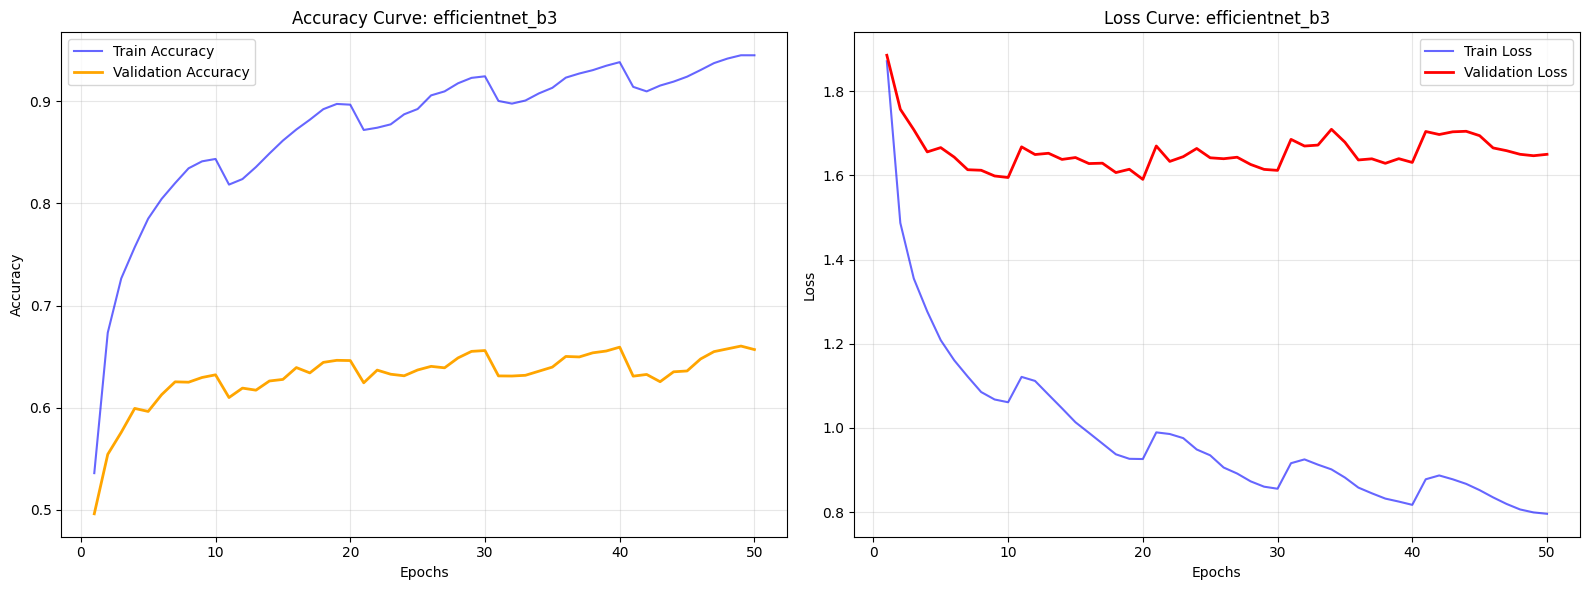

In [18]:
# ==========================================
# Cell 3: Plot Training Curves (Current Model)
# ==========================================
if final_data:
    epochs = range(1, len(final_data['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy
    ax1.plot(epochs, final_data['train_acc'], label='Train Accuracy', color='blue', alpha=0.6)
    ax1.plot(epochs, final_data['val_acc'], label='Validation Accuracy', color='orange', linewidth=2)
    ax1.set_title(f'Accuracy Curve: {MODEL_TYPE}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(epochs, final_data['train_loss'], label='Train Loss', color='blue', alpha=0.6)
    ax2.plot(epochs, final_data['val_loss'], label='Validation Loss', color='red', linewidth=2)
    ax2.set_title(f'Loss Curve: {MODEL_TYPE}')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

C:\Users\AM\AppData\Local\Temp\ipykernel_7488\2996519066.py:42: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.savefig('results/figures/final_comparison.png', dpi=300)


✅ Comparison plot saved to results/figures/final_comparison.png


c:\Users\AM\anaconda3\envs\art_project\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


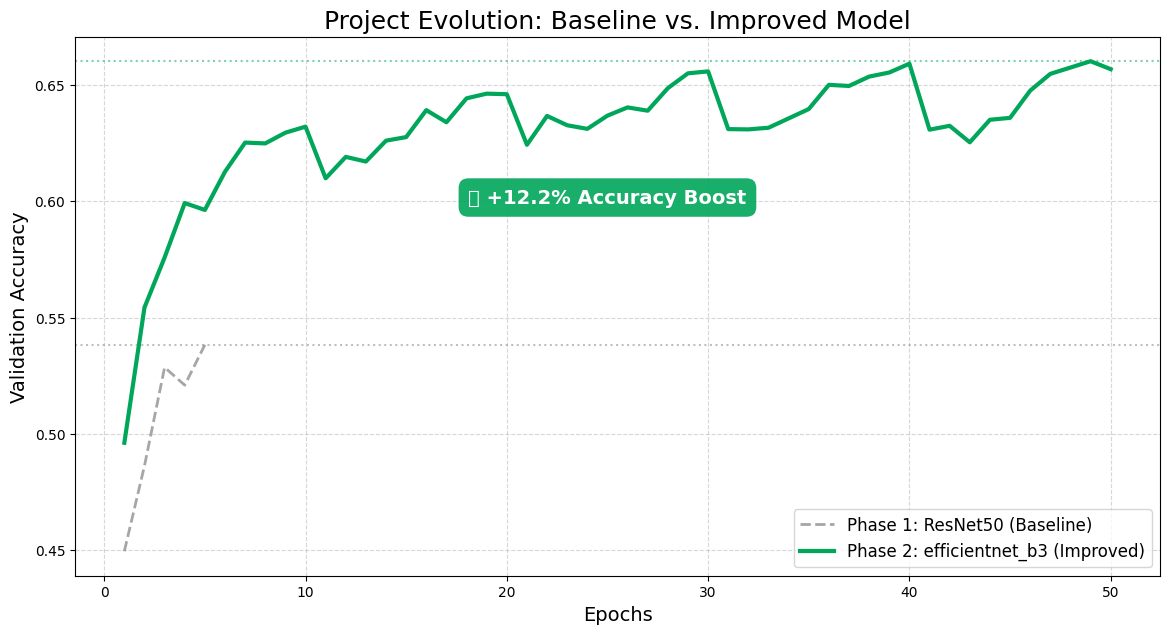

In [19]:
# ==========================================
# Cell 4: Comparison Plot (The "Money Shot" 📉)
# ==========================================
plt.figure(figsize=(14, 7))

# Plot Baseline
if baseline_data:
    epochs_base = range(1, len(baseline_data['val_acc']) + 1)
    plt.plot(epochs_base, baseline_data['val_acc'], 
             label='Phase 1: ResNet50 (Baseline)', 
             linestyle='--', color='gray', alpha=0.7, linewidth=2)

# Plot Final
if final_data:
    epochs_final = range(1, len(final_data['val_acc']) + 1)
    plt.plot(epochs_final, final_data['val_acc'], 
             label=f'Phase 2: {MODEL_TYPE} (Improved)', 
             linewidth=3, color='#00a65a') # Green color

plt.title('Project Evolution: Baseline vs. Improved Model', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate Improvement
if baseline_data and final_data:
    best_base = max(baseline_data['val_acc'])
    best_final = max(final_data['val_acc'])
    improvement = (best_final - best_base) * 100
    
    plt.axhline(y=best_final, color='#00a65a', linestyle=':', alpha=0.5)
    plt.axhline(y=best_base, color='gray', linestyle=':', alpha=0.5)
    
    plt.text(len(epochs_final)/2, (best_base + best_final)/2, 
             f'🚀 +{improvement:.1f}% Accuracy Boost', 
             fontsize=14, color='white', fontweight='bold', ha='center',
             bbox=dict(facecolor='#00a65a', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.5'))

# Save figure
os.makedirs('results/figures', exist_ok=True)
plt.savefig('results/figures/final_comparison.png', dpi=300)
print("✅ Comparison plot saved to results/figures/final_comparison.png")
plt.show()

In [20]:
# ==========================================
# Cell 5: Load Best Model & Run Inference on Test Set
# ==========================================
import os
import torch
from tqdm.notebook import tqdm
import json

# 1. Load Data
print("\n⏳ Loading Test Data...")

# استفاده از project_root برای مسیردهی صحیح
dataloaders, datasets = create_dataloaders(
    splits_dir=SPLITS_DIR,
    root_dir=project_root, 
    batch_size=BATCH_SIZE,
    num_workers=0 
)
test_loader = dataloaders['test']

# --- FIX: Robust Class Name Loading ---
class_mapping_path = os.path.join(project_root, 'data', 'processed', 'splits', 'class_mapping.json')

if os.path.exists(class_mapping_path):
    with open(class_mapping_path, 'r') as f:
        mapping = json.load(f)
        # mapping فرمتش این شکلی است: {"Abstract": 0, "Cubism": 1, ...}
    
    # روش مطمئن: مرتب‌سازی کلیدها (نام سبک‌ها) بر اساس مقادیرشان (ایندکس‌ها)
    # این خط بدون نیاز به ایندکس دستی، لیست را به ترتیب 0، 1، 2 و... می‌سازد
    class_names = sorted(mapping, key=mapping.get)
    
else:
    print("⚠️ Mapping file not found, using dataset classes directly.")
    class_names = list(datasets['test'].data['style'].unique())
    class_names.sort()

print(f"✅ Class Names Loaded: {class_names[:5]} ...") 
print(f"✅ Test Data Loaded. {len(datasets['test'])} samples.")

# 2. Load Model
print(f"🏗️ Loading Model Weights from {BEST_MODEL_PATH}...")
model = get_model(MODEL_TYPE, num_classes=NUM_CLASSES, device=DEVICE)

if os.path.exists(BEST_MODEL_PATH):
    checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint)
    print("✅ Weights loaded successfully.")
else:
    print(f"❌ Error: Model weights file not found at {BEST_MODEL_PATH}")

# 3. Inference
all_preds = []
all_labels = []

model.eval()
print("🚀 Starting Inference...")

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Standard float32 inference
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("✅ Inference Complete.")


⏳ Loading Test Data...
✅ Class Names Loaded: ['0', '1', '2', '3', '4'] ...
✅ Test Data Loaded. 8452 samples.
🏗️ Loading Model Weights from c:\Computer Engineering\Term7\AI Project\AI-FinalProject-PaintingStyleRecognition-DAM\models\best_model_efficientnet_b3.pth...
✅ Weights loaded successfully.
🚀 Starting Inference...


Testing:   0%|          | 0/265 [00:00<?, ?it/s]

✅ Inference Complete.



📊 Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       417
           1       0.64      0.50      0.56        14
           2       0.92      0.65      0.76        17
           3       0.62      0.69      0.65       600
           4       0.77      0.79      0.78       600
           5       0.78      0.68      0.73       242
           6       0.75      0.60      0.67        72
           7       0.69      0.67      0.68       336
           8       0.75      0.77      0.76       209
           9       0.56      0.43      0.48       600
          10       0.47      0.34      0.40       140
          11       0.68      0.63      0.65       201
          12       0.68      0.64      0.66       600
          13       0.70      0.68      0.69       192
          14       0.65      0.82      0.73       201
          15       0.67      0.79      0.72       361
          16       0.59      0.36      0.45        47


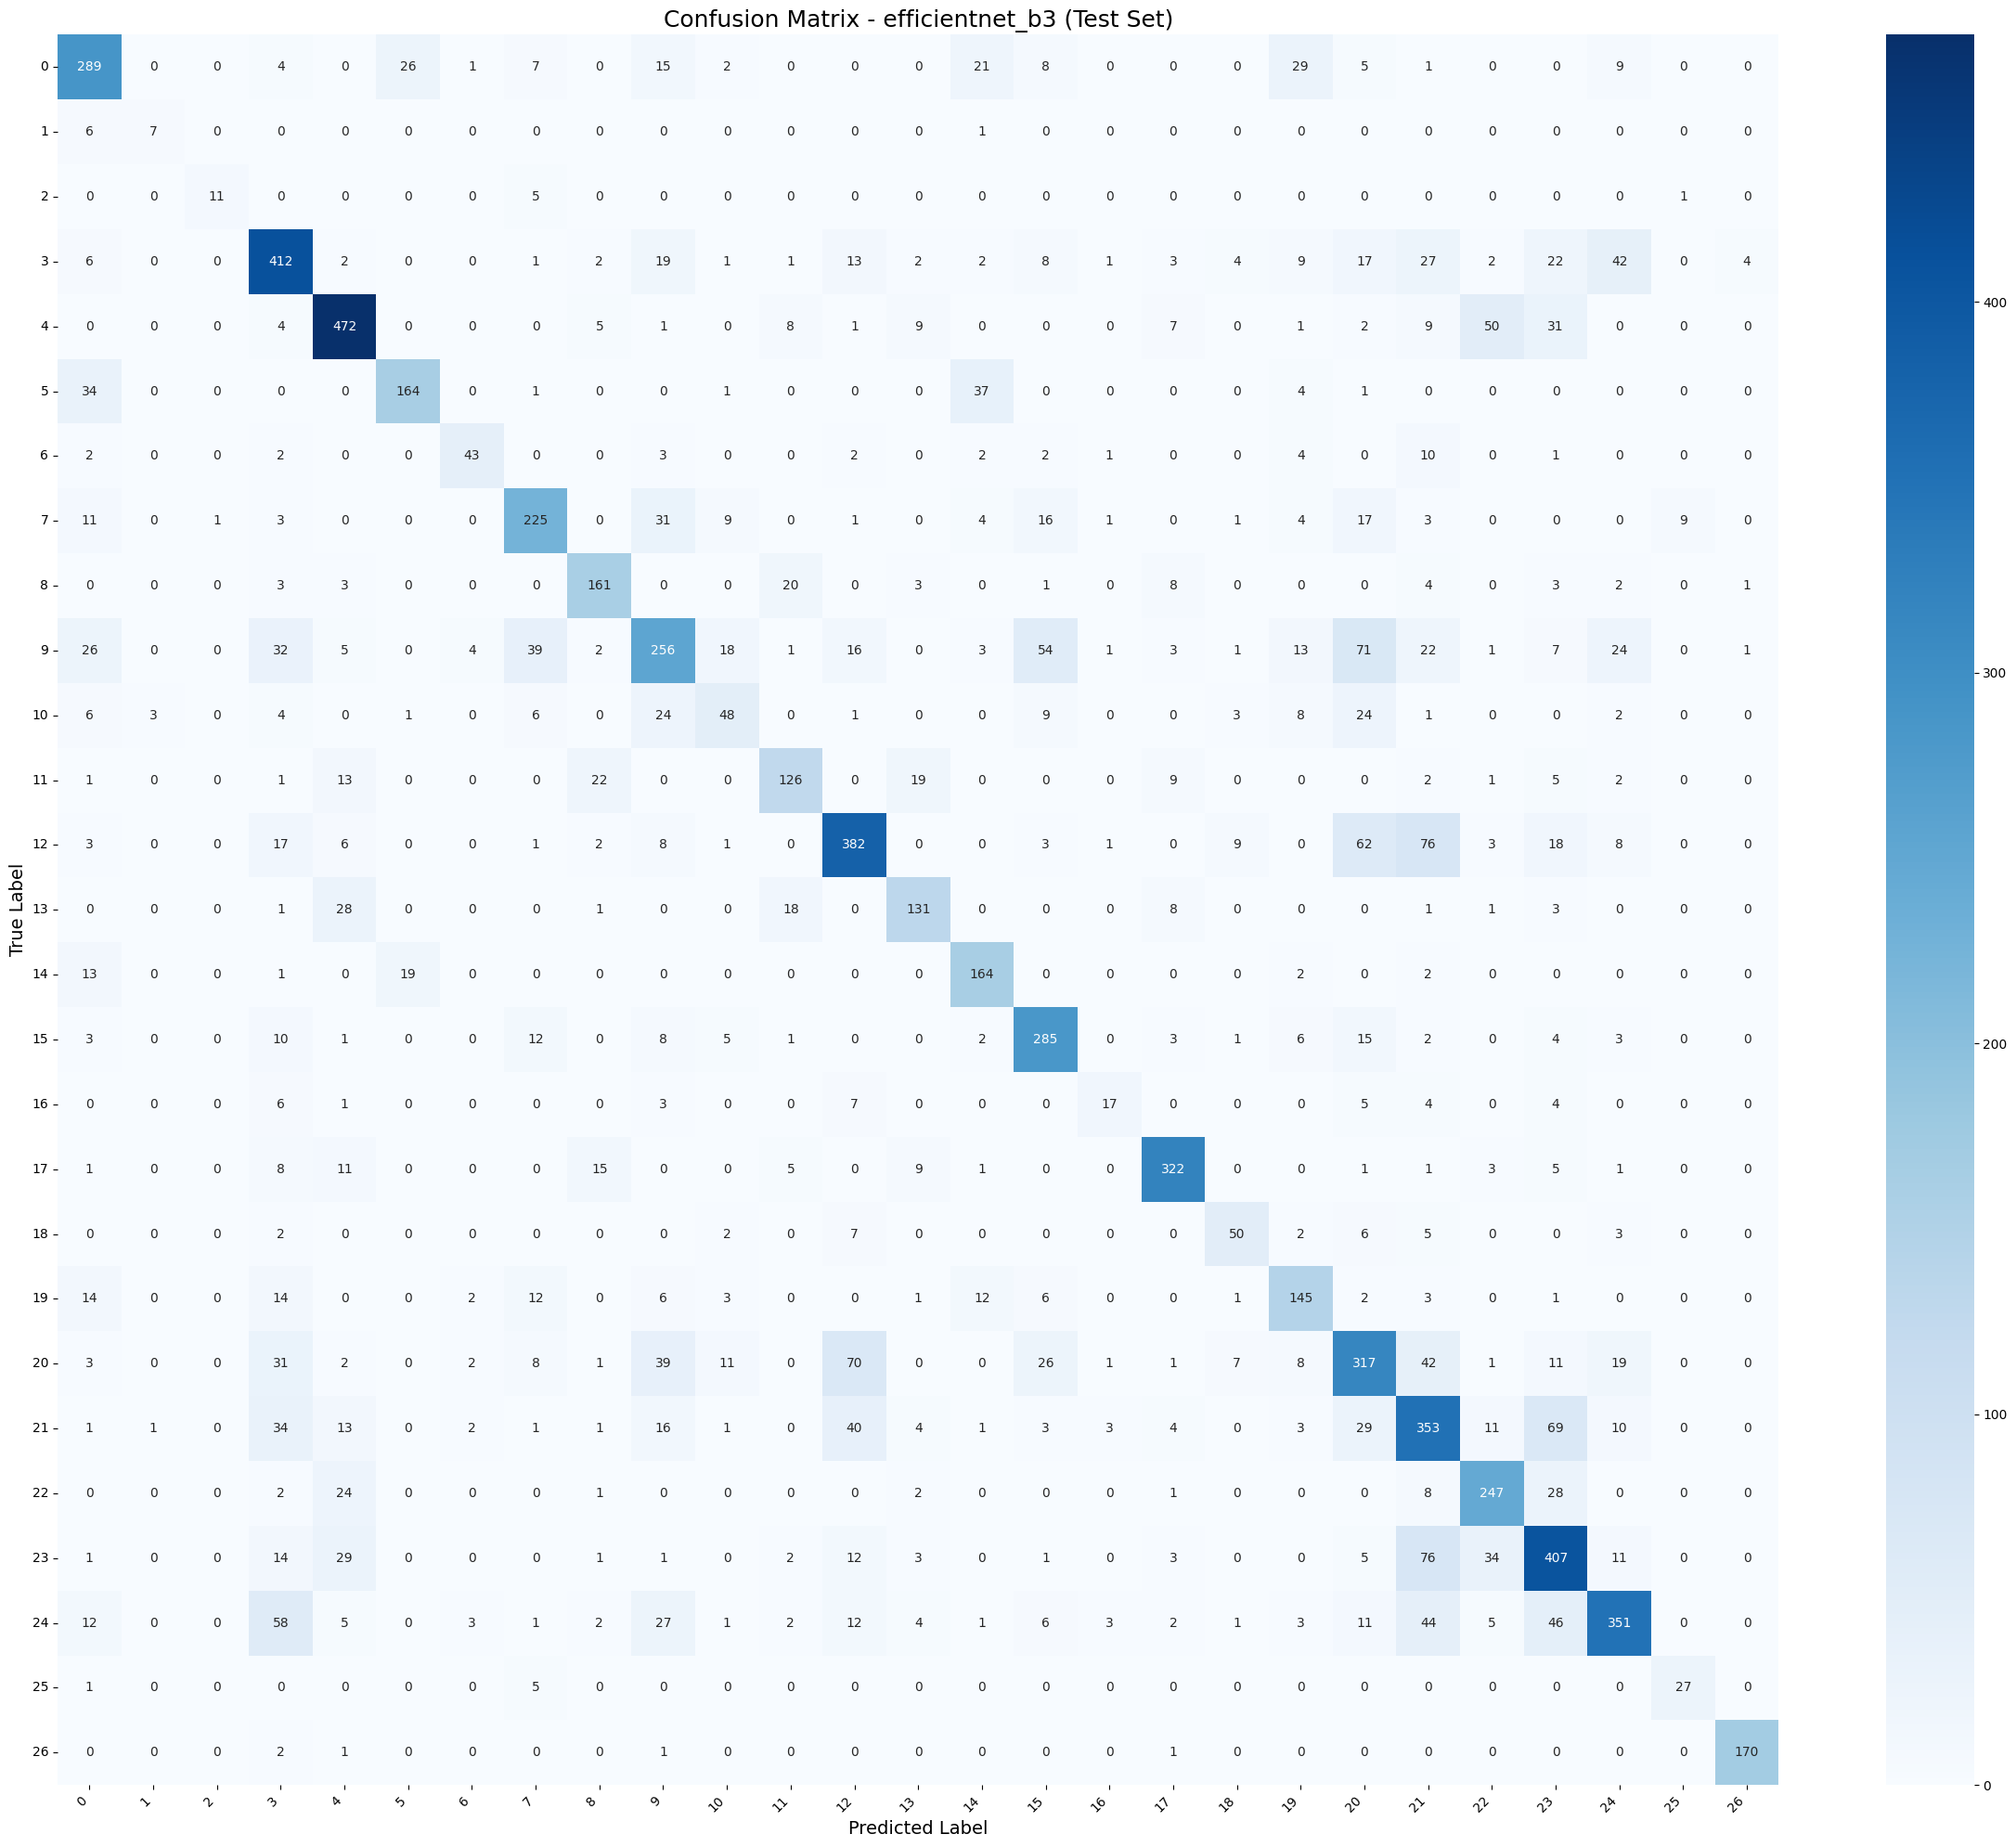

In [21]:
# ==========================================
# Cell 6: Confusion Matrix & Metrics
# ==========================================
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(24, 20)) # Big size for 27 classes 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title(f'Confusion Matrix - {MODEL_TYPE} (Test Set)', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'results/figures/confusion_matrix_{MODEL_TYPE}.png', dpi=300)
plt.show()